# 📑 &nbsp; Deep Learning. Breed Recognition
<a href='https://olgabelitskaya.gitlab.io/index.html'>
&#x1F300; &nbsp; Homepage &nbsp; &nbsp;</a>
<a href='https://olgabelitskaya.gitlab.io/deep_learning_projects/index.html'>
&#x1F300; &nbsp; Project List &nbsp; &nbsp;</a>
<a href='https://olgabelitskaya.github.io/README.html'>
&#x1F300; &nbsp; GitHub Pages &nbsp; &nbsp;</a>
<a href='https://olgabelitskaya.gitlab.io/deep_learning_projects/DL_PP5_0_SMC.html'>&#x1F300; &nbsp; Main &nbsp; &nbsp;</a><br/>
<a href='https://www.instagram.com/olga.belitskaya/'>
&#x1F300; &nbsp; Instagram Posts &nbsp; &nbsp;</a>
<a href='https://www.pinterest.ru/olga_belitskaya/code-style/'>
&#x1F300; &nbsp; Pinterest Posts</a><br/>
For this project, I have created the dataset of about color images with horse breeds.<br/>

## ✒️ &nbsp; Modules, Settings, & Helpful Functions

In [1]:
!python3 -m pip install neural_structured_learning \
--user --quiet --no-warn-script-location

In [2]:
sys_path='/root/.local/lib/python3.6/site-packages'
import sys; sys.path.append(sys_path)
import warnings; warnings.filterwarnings('ignore')
import h5py,urllib,torch,os,imageio
import tensorflow as tf,tensorflow_hub as th
import pandas as pd,numpy as np,pylab as pl,sympy as sp
import tensorflow.keras.layers as tkl
import tensorflow.keras.callbacks as tkc
import neural_structured_learning as nsl
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
from torchvision import transforms,utils,models
import torch.nn.functional as tnnf,torch.nn as tnn
dev=torch.device('cuda:0' \
if torch.cuda.is_available() else 'cpu')
from IPython.core.display import display,HTML,Image
from IPython.core.magic import register_line_magic

In [3]:
file_path='https://raw.githubusercontent.com/OlgaBelitskaya/data_kitchen/main/'
file_name='HorseBreeds160.h5'
img_path='https://olgabelitskaya.gitlab.io/data/horses/'
img_files=['00_05_001.png','00_06_001.png']
img_size=64; data_img_size=160; max_img_size=224
batch_size2=8; img_size2=64
steps=60

 ## ✒️ &nbsp; Data Loading and Preprocessing

In [4]:
def get_file(file_path,file_name):
    input_file=urllib.request.urlopen(file_path+file_name)
    output_file=open(file_name,'wb')
    output_file.write(input_file.read())
    output_file.close(); input_file.close()
get_file(file_path,file_name)
with h5py.File(file_name,'r') as f:
    keys=list(f.keys())
    sp.pretty_print('file keys: '+', '.join(keys))
    images=np.array(f[keys[0]])
    images=tf.image.resize(
        images,[data_img_size,data_img_size]).numpy()
    labels=np.array(f[keys[1]])
    names=[el.decode('utf-8') for el in f[keys[2]]]
    f.close()

file keys: images, labels, names


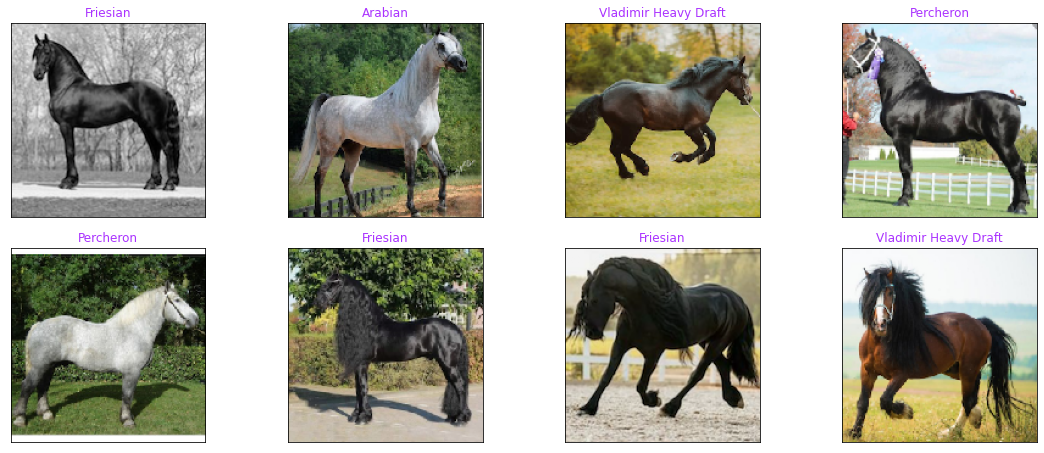

train              valid               test
image shape  (536, 160, 160, 3)  (67, 160, 160, 3)  (67, 160, 160, 3)
image type              float32            float32            float32
label shape              (536,)              (67,)              (67,)
label type                int32              int32              int32

In [5]:
N=labels.shape[0]; n=int(.1*N); num_classes=len(names)
shuffle_ids=np.arange(N)
np.random.RandomState(12).shuffle(shuffle_ids)
images=images[shuffle_ids]; labels=labels[shuffle_ids]
x_test,x_valid,x_train=images[:n],images[n:2*n],images[2*n:]
y_test,y_valid,y_train=labels[:n],labels[n:2*n],labels[2*n:]
df=pd.DataFrame(
    [[x_train.shape,x_valid.shape,x_test.shape],
     [x_train.dtype,x_valid.dtype,x_test.dtype],
     [y_train.shape,y_valid.shape,y_test.shape],
     [y_train.dtype,y_valid.dtype,y_test.dtype]],
    columns=['train','valid','test'],
    index=['image shape','image type','label shape','label type'])
def display_imgs(images,labels,names,fig_size=16,start0=False):
    fig=pl.figure(figsize=(fig_size,fig_size/2.5))
    randi=np.random.randint(0,200)
    if start0==True: randi=0
    for i in range(randi,randi+8):
        ax=fig.add_subplot(2,4,i-randi+1,xticks=[],yticks=[])
        ax.set_title(names[labels[i]],color='#aa33ff',
                     fontdict={'fontsize':'large'})
        ax.imshow((images[i]))
    pl.tight_layout(); pl.show()
display_imgs(images,labels,names); display(df)

In [6]:
class TData(tds):
    def __init__(self,x,y):   
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        img,lbl=self.x[index],self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]
n_train=batch_size2*(x_train.shape[0]//batch_size2)
x_train2=tf.image.resize(x_train,[img_size2,img_size2])
x_train2=np.transpose(x_train2.numpy(),(0,3,1,2))[:n_train]
print(x_train2.mean(),x_train2.std())
n_valid=batch_size2*(x_valid.shape[0]//batch_size2)
x_valid2=tf.image.resize(x_valid,[img_size2,img_size2])
x_valid2=np.transpose(x_valid2.numpy(),(0,3,1,2))[:n_valid]
n_test=batch_size2*(x_test.shape[0]//batch_size2)
x_test2=tf.image.resize(x_test,[img_size2,img_size2])
x_test2=np.transpose(x_test2.numpy(),(0,3,1,2))[:n_test]
random_seed=23
train2=TData(x_train2,y_train[:n_train])
valid2=TData(x_valid2,y_valid[:n_valid])
test2=TData(x_test2,y_test[:n_test])
dataloaders={'train':tdl(dataset=train2,shuffle=True,batch_size=batch_size2), 
             'valid':tdl(dataset=valid2,shuffle=True,batch_size=batch_size2),
             'test':tdl(dataset=test2,shuffle=True,batch_size=batch_size2)}

0.49232626 0.2689173


Image dimensions: torch.Size([8, 3, 64, 64])
Label dimensions: torch.Size([8])


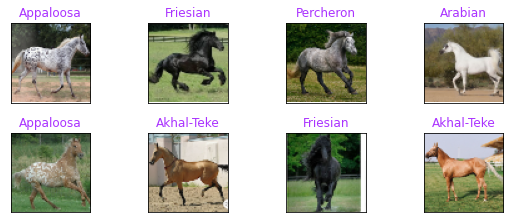

In [7]:
@register_line_magic
def display_data_imgs(data):
    global names
    for images,labels in dataloaders[data]:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        images=[np.transpose(images[i],(1,2,0)) 
                for i in range(len(images))]
        display_imgs(images,labels,names,fig_size=8,start0=True)
        break
%display_data_imgs valid

## ✒️ &nbsp; Classification Models
### TFHub

In [8]:
def keras_history_plot(fit_history,fig_size=12,color='#aa33ff'):
    keys=list(fit_history.history.keys())
    list_history=[fit_history.history[keys[i]] 
                  for i in range(len(keys))]
    dfkeys=pd.DataFrame(list_history).T
    dfkeys.columns=keys
    fig=pl.figure(figsize=(fig_size,fig_size//2))
    ax1=fig.add_subplot(2,1,1)
    dfkeys.iloc[:,[int(0),int(2)]].plot(
        ax=ax1,color=['slategray',color],grid=True)
    ax2=fig.add_subplot(2,1,2)
    dfkeys.iloc[:,[int(1),int(3)]].plot(
        ax=ax2,color=['slategray',color],grid=True)
    pl.tight_layout(); pl.show()

In [9]:
def premodel(pix,den,mh,lbl,activ,loss):
    model=tf.keras.Sequential([
        tkl.Input((pix,pix,3),name='input'),
        th.KerasLayer(mh,trainable=True),
        tkl.Flatten(),
        tkl.Dense(den,activation='relu'),
        tkl.Dropout(rate=.5),
        tkl.Dense(lbl,activation=activ)])
    model.compile(optimizer='adam',metrics=['accuracy'],loss=loss)
    display(model.summary())
    return model

In [10]:
handle_base='mobilenet_v2_100_160'
mhandle='https://tfhub.dev/google/imagenet/{}/classification/4'\
.format(handle_base)

In [11]:
fw='/tmp/checkpoint'
early_stopping=tkc.EarlyStopping(
    monitor='val_loss',patience=20,verbose=2)
checkpointer=tkc.ModelCheckpoint(
    filepath=fw,verbose=int(0),save_weights_only=True,
    monitor='val_accuracy',mode='max',save_best_only=True)
lr_reduction=tkc.ReduceLROnPlateau(
    monitor='val_loss',verbose=2,patience=5,factor=.8)
kmodel=premodel(data_img_size,2048,mhandle,num_classes,
                'softmax','sparse_categorical_crossentropy')
history=kmodel.fit(x=x_train,y=y_train,batch_size=16,epochs=50,
                   callbacks=[checkpointer,early_stopping,lr_reduction],
                   validation_data=(x_valid,y_valid))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
_________________________________________________________________
flatten (Flatten)            (None, 1001)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              2052096   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 14343     
Total params: 5,606,704
Trainable params: 5,572,592
Non-trainable params: 34,112
_________________________________________________________________


None

Epoch 1/50
34/34 [==============================] - 12s 120ms/step - loss: 2.1789 - accuracy: 0.4674 - val_loss: 7.1744 - val_accuracy: 0.5075
Epoch 2/50
34/34 [==============================] - 2s 65ms/step - loss: 1.2969 - accuracy: 0.6206 - val_loss: 3.3123 - val_accuracy: 0.5672
Epoch 3/50
34/34 [==============================] - 2s 65ms/step - loss: 0.9980 - accuracy: 0.7454 - val_loss: 3.4183 - val_accuracy: 0.6269
Epoch 4/50
34/34 [==============================] - 2s 65ms/step - loss: 0.9345 - accuracy: 0.8089 - val_loss: 3.6979 - val_accuracy: 0.4328
Epoch 5/50
34/34 [==============================] - 2s 65ms/step - loss: 0.8539 - accuracy: 0.7979 - val_loss: 2.7725 - val_accuracy: 0.5970
Epoch 6/50
34/34 [==============================] - 2s 66ms/step - loss: 1.0396 - accuracy: 0.7263 - val_loss: 8.3741 - val_accuracy: 0.4925
Epoch 7/50
34/34 [==============================] - 2s 65ms/step - loss: 0.9142 - accuracy: 0.8260 - val_loss: 29.6730 - val_accuracy: 0.3582
Epoch 8/50

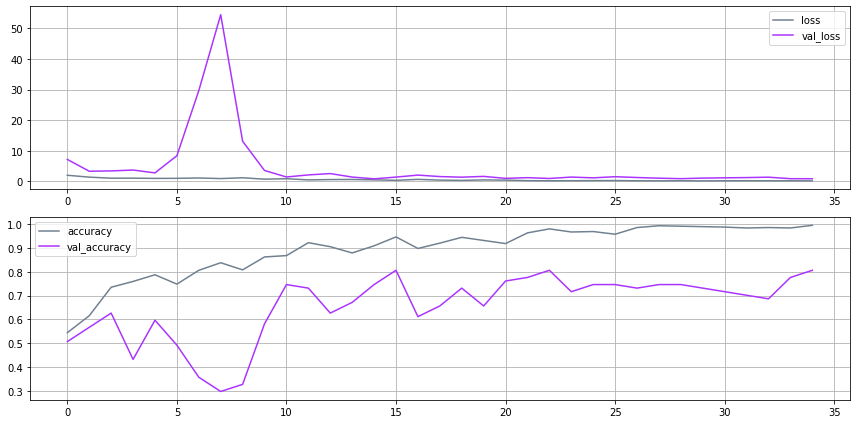

In [12]:
keras_history_plot(history)

In [13]:
kmodel.load_weights(fw)
sp.pretty_print(kmodel.evaluate(x_test,y_test,verbose=0))
y_test_predict=np.argmax(kmodel.predict(x_test),axis=-1)
y_test_predict,y_test

[0.8902252912521362, 0.8059701323509216]


(array([0, 4, 2, 0, 1, 2, 1, 0, 2, 5, 4, 0, 2, 6, 0, 2, 6, 4, 6, 1, 0, 6,
        6, 3, 5, 1, 3, 0, 0, 1, 2, 2, 2, 6, 6, 5, 3, 6, 5, 6, 5, 1, 0, 4,
        4, 0, 3, 0, 4, 0, 2, 4, 0, 0, 6, 6, 4, 1, 0, 5, 4, 5, 1, 5, 3, 6,
        0]),
 array([0, 5, 2, 0, 1, 2, 1, 0, 2, 5, 4, 0, 4, 6, 0, 2, 6, 6, 6, 1, 0, 6,
        6, 4, 5, 1, 3, 0, 0, 1, 4, 2, 2, 6, 6, 5, 3, 6, 5, 6, 1, 1, 0, 2,
        4, 5, 4, 0, 4, 0, 2, 4, 5, 0, 5, 6, 5, 1, 0, 5, 4, 5, 1, 5, 3, 6,
        5], dtype=int32))

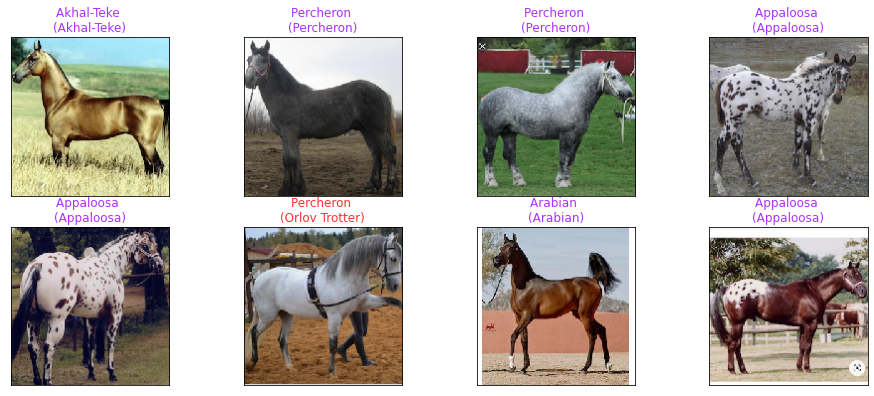

In [14]:
fig=pl.figure(figsize=(16,16/2.5))
randch=np.random.choice(
    x_test.shape[0],size=8,replace=False)
for i,idx in enumerate(randch):
    ax=fig.add_subplot(2,4,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx=y_test_predict[idx]
    true_idx=y_test[idx]
    ax.set_title('{} \n({})'.format(
        names[pred_idx],names[true_idx]),
        color=('#aa33ff' if pred_idx==true_idx else '#ff3333'))
pl.show()

In [15]:
def kmodel(leaky_alpha,num_classes=num_classes):
    model=tf.keras.Sequential()
    model.add(tkl.Conv2D(
        32,(5,5),padding='same', 
        input_shape=[data_img_size,data_img_size,3]))
    model.add(tkl.LeakyReLU(alpha=leaky_alpha))    
    model.add(tkl.MaxPooling2D(pool_size=(2,2)))
    model.add(tkl.Dropout(.25))
    model.add(tkl.Conv2D(196,(5,5)))
    model.add(tkl.LeakyReLU(alpha=leaky_alpha))    
    model.add(tkl.MaxPooling2D(pool_size=(2,2)))
    model.add(tkl.Dropout(.25))   
    model.add(tkl.GlobalMaxPooling2D())     
    model.add(tkl.Dense(1024))
    model.add(tkl.LeakyReLU(alpha=leaky_alpha))
    model.add(tkl.Dropout(.5))     
    model.add(tkl.Dense(num_classes))
    model.add(tkl.Activation('softmax'))   
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='nadam',metrics=['accuracy'])   
    return model
kmodel=kmodel(.01)

In [16]:
early_stopping=tkc.EarlyStopping(
    monitor='val_loss',patience=20,verbose=2)
checkpointer=tkc.ModelCheckpoint(
    filepath=fw,verbose=0,save_weights_only=True,
    monitor='val_accuracy',mode='max',save_best_only=True)
lr_reduction=tkc.ReduceLROnPlateau(
    monitor='val_loss',verbose=2,patience=5,factor=.8)
history=kmodel.fit(x_train,y_train,epochs=70,batch_size=16,verbose=2,
                   validation_data=(x_valid,y_valid),
                   callbacks=[checkpointer,early_stopping,lr_reduction])

Epoch 1/70
34/34 - 3s - loss: 1.9341 - accuracy: 0.1735 - val_loss: 1.8992 - val_accuracy: 0.1045
Epoch 2/70
34/34 - 1s - loss: 1.8535 - accuracy: 0.2276 - val_loss: 1.8183 - val_accuracy: 0.3582
Epoch 3/70
34/34 - 1s - loss: 1.7815 - accuracy: 0.3246 - val_loss: 1.7444 - val_accuracy: 0.4627
Epoch 4/70
34/34 - 1s - loss: 1.6742 - accuracy: 0.3601 - val_loss: 1.6417 - val_accuracy: 0.4030
Epoch 5/70
34/34 - 1s - loss: 1.6477 - accuracy: 0.3769 - val_loss: 1.6667 - val_accuracy: 0.2985
Epoch 6/70
34/34 - 1s - loss: 1.5672 - accuracy: 0.4011 - val_loss: 1.5758 - val_accuracy: 0.4478
Epoch 7/70
34/34 - 1s - loss: 1.4912 - accuracy: 0.4422 - val_loss: 1.5662 - val_accuracy: 0.4776
Epoch 8/70
34/34 - 1s - loss: 1.4519 - accuracy: 0.4347 - val_loss: 1.6298 - val_accuracy: 0.2687
Epoch 9/70
34/34 - 1s - loss: 1.3627 - accuracy: 0.4925 - val_loss: 1.4264 - val_accuracy: 0.5373
Epoch 10/70
34/34 - 1s - loss: 1.2369 - accuracy: 0.5448 - val_loss: 1.2770 - val_accuracy: 0.4776
Epoch 11/70
34/34 -

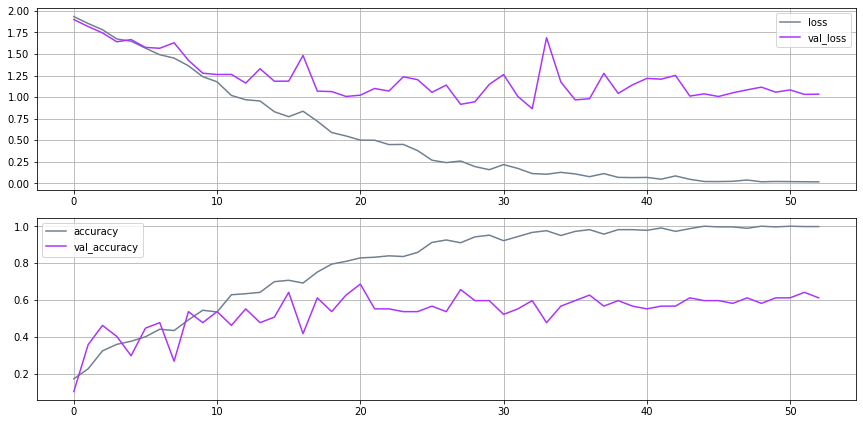

In [17]:
keras_history_plot(history)

In [18]:
kmodel.load_weights(fw)
sp.pretty_print(kmodel.evaluate(x_test,y_test,verbose=int(0)))
y_test_predict=np.argmax(kmodel.predict(x_test),axis=-1)

[0.9524329900741577, 0.5820895433425903]


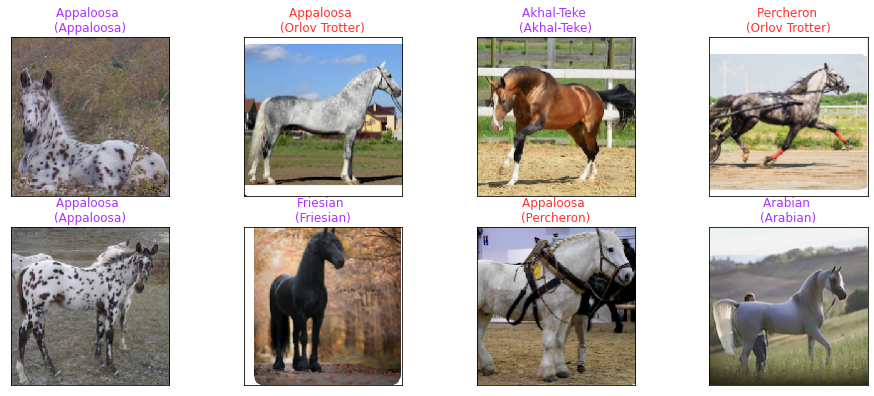

In [19]:
fig=pl.figure(figsize=(16,16/2.5))
randch=np.random.choice(
    x_test.shape[0],size=8,replace=False)
for i,idx in enumerate(randch):
    ax=fig.add_subplot(2,4,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx=y_test_predict[idx]
    true_idx=y_test[idx]
    ax.set_title('{} \n({})'.format(
        names[pred_idx],names[true_idx]),
        color=('#aa33ff' if pred_idx==true_idx else '#ff3333'))
pl.show()

### PyTorch Models

In [20]:
tmodel=models.vgg16(pretrained=True)
for param in tmodel.parameters(): param.requires_grad=False
tmodel.classifier[3].requires_grad=True
tmodel

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
def model_acc(model,data_loader):
    correct_preds,num_examples=0,0    
    for features,targets in data_loader:
        features=features.to(dev)
        targets=targets.to(dev).long()
        logits=model(features)
        _,pred_labels=torch.max(logits,1)
        num_examples+=targets.size(0)
        correct_preds+=(pred_labels==targets).sum()        
    return correct_preds.float()/num_examples*100
def epoch_loss(model,data_loader):
    model.eval()
    curr_loss,num_examples=0.,0
    with torch.no_grad():
        for features,targets in data_loader:
            features=features.to(dev)
            targets=targets.to(dev).long()
            logits=model(features)
            loss=tnnf.cross_entropy(logits,targets,
                                    reduction='sum')
            num_examples+=targets.size(0)
            curr_loss+=loss
        return curr_loss/num_examples

In [22]:
@register_line_magic
def train_run(epochs):
    epochs=int(epochs)
    for epoch in range(epochs):
        tmodel.train()
        for batch_ids,(features,targets) \
        in enumerate(dataloaders['train']):        
            features=features.to(dev)
            targets=targets.to(dev).long()
            logits=tmodel(features)
            cost=tnnf.cross_entropy(logits,targets)
            optimizer.zero_grad(); cost.backward()
            optimizer.step()
            str1='epoch: %03d/%03d | batch: %03d/%03d | cost: %.4f'
            if not batch_ids%10:
                sp.pretty_print(str1%(epoch+1,epochs,batch_ids,
                                      len(dataloaders['train']),cost))
        tmodel.eval()
        with torch.set_grad_enabled(False):
            sp.pretty_print('epoch: %03d/%03d'%(epoch+1,epochs))
            str2='train acc/loss: %.2f%%/%.2f valid acc/loss: %.2f%%/%.2f'
            sp.pretty_print(str2%\
                  (model_acc(tmodel,dataloaders['train']),
                   epoch_loss(tmodel,dataloaders['train']),
                   model_acc(tmodel,dataloaders['valid']),
                   epoch_loss(tmodel,dataloaders['valid'])))

In [23]:
tmodel.classifier[6]=tnn.Sequential(
    tnn.Linear(4096,512),tnn.ReLU(),
    tnn.Dropout(.5),tnn.Linear(512,num_classes))
tmodel=tmodel.to(dev)
optimizer=torch.optim.Adam(tmodel.parameters())

In [24]:
%train_run 15

epoch: 001/015 | batch: 000/067 | cost: 1.9818
epoch: 001/015 | batch: 010/067 | cost: 1.6795
epoch: 001/015 | batch: 020/067 | cost: 1.2938
epoch: 001/015 | batch: 030/067 | cost: 1.8525
epoch: 001/015 | batch: 040/067 | cost: 1.5572
epoch: 001/015 | batch: 050/067 | cost: 0.8837
epoch: 001/015 | batch: 060/067 | cost: 1.6571
epoch: 001/015
train acc/loss: 51.68%/1.38 valid acc/loss: 60.94%/1.24
epoch: 002/015 | batch: 000/067 | cost: 0.8609
epoch: 002/015 | batch: 010/067 | cost: 1.0366
epoch: 002/015 | batch: 020/067 | cost: 0.4631
epoch: 002/015 | batch: 030/067 | cost: 1.8029
epoch: 002/015 | batch: 040/067 | cost: 1.6054
epoch: 002/015 | batch: 050/067 | cost: 1.2230
epoch: 002/015 | batch: 060/067 | cost: 1.6469
epoch: 002/015
train acc/loss: 73.32%/0.83 valid acc/loss: 60.94%/1.04
epoch: 003/015 | batch: 000/067 | cost: 1.9613
epoch: 003/015 | batch: 010/067 | cost: 0.5809
epoch: 003/015 | batch: 020/067 | cost: 1.2596
epoch: 003/015 | batch: 030/067 | cost: 0.4702
epoch: 003/0

In [25]:
tmodel.eval()
with torch.set_grad_enabled(False):
    print('train acc: %.2f%% | test acc: %.2f%%'%\
          (model_acc(tmodel,dataloaders['train']),
           model_acc(tmodel,dataloaders['test'])))

train acc: 89.37% | test acc: 51.56%


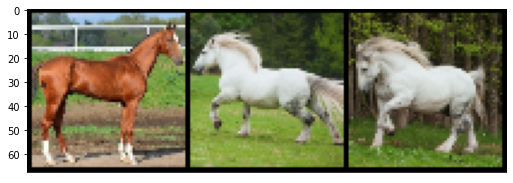


true labels:            Akhal-Teke           Percheron           Percheron

predictions:            Akhal-Teke       Orlov Trotter       Orlov Trotter


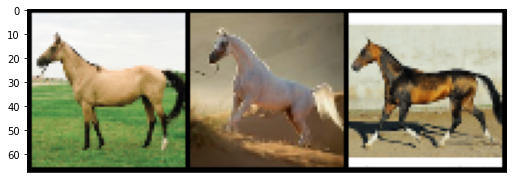


true labels:            Akhal-Teke             Arabian          Akhal-Teke

predictions:            Akhal-Teke       Orlov Trotter          Akhal-Teke


In [26]:
def show_image(img):
    npimg=img.numpy(); tr=(1,2,0)
    pl.figure(figsize=(12,3))
    pl.imshow(np.transpose(npimg,tr))
    pl.xticks([]); pl.show()
with torch.no_grad():
    for i,(timages,tlabels) in enumerate(dataloaders['test']):
        show_image(utils.make_grid(timages[:3]))
        print('\ntrue labels: ',
              ''.join('%20s'%names[tlabels[j]] for j in range(3)))
        timages=timages.to(dev)
        tlabels=tlabels.to(dev)
        outputs=tmodel(timages)
        _,tpreds=torch.max(outputs,1)
        print('\npredictions: ',
             ''.join('%20s'%names[tpreds[j]] for j in range(3)))
        if i==1: break

## ✒️ &nbsp; Super Resolution

In [27]:
def esrgantf2_superresolution(img,img_size=50):
    model=th.load('https://tfhub.dev/captain-pool/esrgan-tf2/1')
    func=model.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
    func.inputs[0].set_shape([1,img_size,img_size,3])
    converter=tf.lite.TFLiteConverter.from_concrete_functions([func])
    converter.optimizations=[tf.lite.Optimize.DEFAULT]
    tflite_model=converter.convert()
    with tf.io.gfile.GFile('ESRGAN.tflite','wb') as f:
        f.write(tflite_model)
    esrgan_model_path='./ESRGAN.tflite'
    if img.mean()<1.: img=img*255.
    lr=tf.image.resize(img,[img_size,img_size])
    lr=tf.expand_dims(lr.numpy()[:,:,:int(3)],axis=int(0))
    lr=tf.cast(lr,tf.float32)
    interpreter=tf.lite.Interpreter(model_path=esrgan_model_path)
    interpreter.allocate_tensors()
    input_details=interpreter.get_input_details()
    output_details=interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'],lr)
    interpreter.invoke()
    output_data=interpreter.get_tensor(output_details[0]['index'])
    sr=tf.squeeze(output_data,axis=0)
    sr=tf.clip_by_value(sr,0,255)
    sr=tf.round(sr); sr=tf.cast(sr,tf.uint8)
    lr=tf.cast(tf.squeeze(lr,axis=0),tf.uint8)
    return lr,sr
img=images[0]
lr,sr=esrgantf2_superresolution(img,img_size)

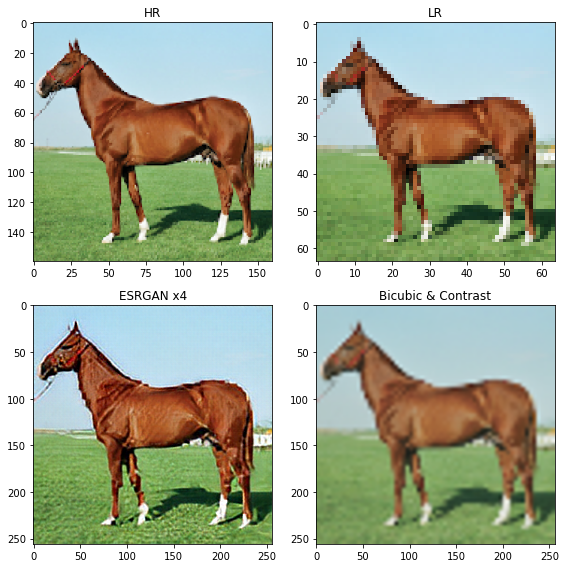

In [28]:
def low2superbicubic_imgs(img,lr,sr,img_size=img_size):
    pl.figure(figsize=(8,8))
    pl.subplot(2,2,1); pl.title('HR'); pl.imshow(img)
    pl.subplot(2,2,2); pl.title('LR'); pl.imshow(lr.numpy())
    pl.subplot(2,2,3); pl.title('ESRGAN x4'); pl.imshow(sr.numpy())
    bicubic=tf.image.resize(
        lr,[img_size*int(4),img_size*int(4)],tf.image.ResizeMethod.BICUBIC)
    bicubic_contrast=tf.image.adjust_contrast(bicubic,float(.8))
    bicubic_contrast=tf.cast(bicubic_contrast,tf.uint8)
    pl.subplot(2,2,4); pl.title('Bicubic & Contrast')
    pl.imshow(bicubic_contrast.numpy())
    pl.tight_layout(); pl.show()
low2superbicubic_imgs(img,lr,sr)

## ✒️  Color Interpolation

In [29]:
def interpolate_hypersphere(v1,v2,steps):
    v1norm=tf.norm(v1); v2norm=tf.norm(v2)
    vectors=[]; v2normalized=v2*(v1norm/v2norm)
    for step in range(steps):
        interpolated=v1+(v2normalized-v1)*step/(steps-int(1))
        interpolated_norm=tf.norm(interpolated)
        interpolated_normalized=interpolated*(v1norm/interpolated_norm)
        vectors.append(interpolated_normalized)
    return tf.stack(vectors).numpy()
imgs=tf.concat([interpolate_hypersphere(x_valid[0],x_test[0],steps),
                interpolate_hypersphere(x_test[0],x_valid[0],steps)],
               axis=0)  

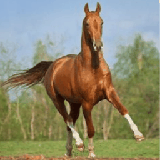

In [30]:
file_name='pic.gif'
imgs=np.array(imgs*float(255),dtype=np.uint8)\
.reshape(2*steps,data_img_size,data_img_size,3)
imageio.mimsave(file_name,imgs)
Image(open('pic.gif','rb').read())

## ✒️  Object Recognition

In [31]:
from tensorflow.keras.applications import vgg19,VGG19
mvgg19=VGG19(include_top=True,weights='imagenet')

In [32]:
def load_img(img_file,max_img_size=max_img_size):
    img=tf.io.read_file(img_file)
    img=tf.image.decode_image(img,channels=3)
    img=tf.image.convert_image_dtype(img,tf.float32)
    shape=tf.cast(tf.shape(img)[:-int(1)],tf.float32)
    scale=max_img_size/max(shape)
    new_shape=tf.cast(shape*scale,tf.int32)
    img=tf.image.resize(img,new_shape)
    return img[tf.newaxis,:]
def tensor2img(tensor):
    if np.ndim(tensor)>int(3):
        assert tensor.shape[0]==1
        tensor=tensor[0]
    pl.figure(figsize=(3,3)); pl.imshow(tensor)
    pl.tight_layout(); pl.show()
for f in img_files:
    input_file=urllib.request.urlopen(img_path+f)
    output_file=open(f,'wb')
    output_file.write(input_file.read())
    output_file.close(); input_file.close()

example #1


class name      prob
0               sorrel  0.994069
1         Ibizan_hound  0.002617
2  Rhodesian_ridgeback  0.001144
3               Saluki  0.000506
4              basenji  0.000221

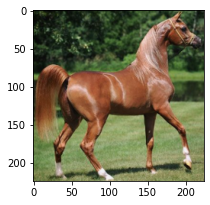

example #2


class name      prob
0       curly-coated_retriever  0.292417
1           Scottish_deerhound  0.178905
2        flat-coated_retriever  0.047128
3  German_short-haired_pointer  0.043551
4              standard_poodle  0.042754

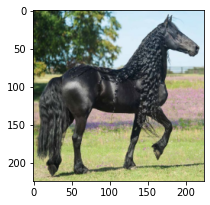

In [33]:
for i in range(len(img_files)):
    content_img=load_img(img_files[i])
    x=vgg19.preprocess_input(content_img*255)
    prediction_probabilities=mvgg19(x)
    predict_top5=vgg19.decode_predictions(
        prediction_probabilities.numpy())[0]
    sp.pretty_print('example #%d'%(i+1))
    display(pd.DataFrame(
        [[class_name,prob] for (number,class_name,prob) in predict_top5],
        columns=['class name','prob']))
    tensor2img(content_img)